In [136]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import time

from sympy.abc import alpha

In [137]:
lorenz_data = np.load('data\\lorenz_training.npy')

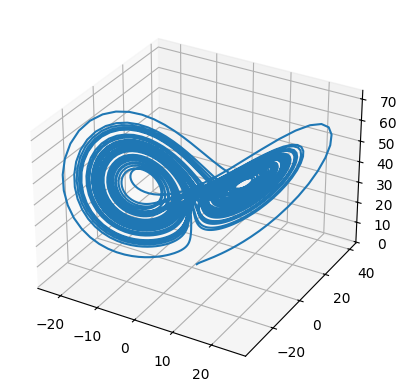

In [138]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(lorenz_data[:, 0], lorenz_data[:, 1], lorenz_data[:, 2])

In [139]:
lorenz_data = np.load('data/lorenz_training.npy')  # shape: (5001, 3)

t_lorenz = np.linspace(0, 0.01 * (lorenz_data.shape[0] - 1), lorenz_data.shape[0])  # shape: (5001,)

T_r = torch.tensor(t_lorenz.reshape(-1, 1), dtype=torch.float32)  # all points for physics
U_data = torch.tensor(lorenz_data[:], dtype=torch.float32)     # every 10th point for supervision
T_data = torch.tensor(t_lorenz[:].reshape(-1, 1), dtype=torch.float32)


In [140]:
U_data

tensor([[ 1.0000,  1.0000,  1.0000],
        [ 1.0173,  1.3893,  0.9872],
        [ 1.0677,  1.7885,  0.9791],
        ...,
        [ 0.1735, -4.1391, 34.7293],
        [-0.2036, -4.0994, 33.8726],
        [-0.5452, -4.0867, 33.0516]])

In [141]:
class PINNIdentificationNet(nn.Module):
    """Set basic architecture of the PINN model in PyTorch."""

    def __init__(self,
                 output_dim=3,
                 num_hidden_layers=6,
                 num_neurons_per_layer=64,
                 activation='tanh'):
        super(PINNIdentificationNet, self).__init__()

        self.num_hidden_layers = num_hidden_layers
        self.output_dim = output_dim

        # Define activation function
        if activation == 'tanh':
            self.activation = torch.tanh
        elif activation == 'relu':
            self.activation = F.relu
        else:
            raise ValueError(f"Unsupported activation: {activation}")

        # Build the network layers
        self.hidden = nn.ModuleList()
        self.hidden.append(nn.Linear(1, num_neurons_per_layer))
        for _ in range(1, num_hidden_layers):
            self.hidden.append(nn.Linear(num_neurons_per_layer, num_neurons_per_layer))
        self.out = nn.Linear(num_neurons_per_layer, output_dim)

        # Trainable physical parameters
        self.sigma = nn.Parameter(torch.tensor(10.0, dtype=torch.float32))
        self.rho = nn.Parameter(torch.tensor(30.0, dtype=torch.float32))
        self.beta = nn.Parameter(torch.tensor(3.0, dtype=torch.float32))

        # For tracking evolution
        self.sigma_list = []
        self.rho_list = []
        self.beta_list = []

    def forward(self, T):
        """Forward-pass through neural network."""
        Z = self.activation(self.hidden[0](T))
        for i in range(1, self.num_hidden_layers):
            Z = self.activation(self.hidden[i](Z))
        return self.out(Z)

In [147]:
class PINNSolver_Lorenz_ID:
    def __init__(self, model, T_r, eps=0.5):
        self.model = model
        self.t = T_r[:, 0:1].clone().detach().requires_grad_(True)
        self.hist = []
        self.iter = 0
        self.eps = eps

    def get_r(self):
        """Compute the residuals of the Lorenz system."""
        u = self.model(self.t)  # u: [x, y, z]
        x, y, z = u[:, 0:1], u[:, 1:2], u[:, 2:3]

        # Create gradient outputs of appropriate shape
        ones = torch.ones_like(x)

        # Calculate gradients for each point individually
        dx_dt = autograd.grad(x, self.t, grad_outputs=ones, create_graph=True)[0]
        dy_dt = autograd.grad(y, self.t, grad_outputs=ones, create_graph=True)[0]
        dz_dt = autograd.grad(z, self.t, grad_outputs=ones, create_graph=True)[0]

        # Lorenz residuals
        r1 = dx_dt - self.model.sigma * (y - x)
        r2 = dy_dt - (x * (self.model.rho - z) - y)
        r3 = dz_dt - (x * y - self.model.beta * z)
        return r1, r2, r3

    def loss_fn(self, T, u_data):
        r1, r2, r3 = self.get_r()
        phi_r = self.eps * (torch.mean(r1**2) + torch.mean(r2**2) + torch.mean(r3**2))
        self.physics_loss = phi_r

        T = T.clone().detach().requires_grad_(True)
        u_pred = self.model(T)  # shape: [N_data, 3]
        phi_data = (1 - self.eps) * torch.mean((u_data - u_pred)**2)
        # add initial condition with x0 = 1, y0 = 1, z0 = 1
        u0 = self.model(torch.tensor([[0.0]]))
        u0 = u0.squeeze()
        u0_target = torch.tensor([1.0, 1.0, 1.0], dtype=torch.float32)
        phi_ic = torch.mean((u0 - u0_target)**2)
        self.ic_loss = phi_ic

        self.data_loss = phi_data

        return 1000*self.data_loss+self.physics_loss + 100*self.ic_loss


    def solve(self, optimizer, T, u_data, N=10000):
        for i in range(N):
            optimizer.zero_grad()
            loss = self.loss_fn(T, u_data)
            loss.backward()
            # 添加梯度裁剪
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            optimizer.step()

            self.current_loss = loss.item()
            self.callback()

    def callback(self):
        sigma = self.model.sigma.item()
        self.model.sigma_list.append(sigma)

        rho = self.model.rho.item()
        self.model.rho_list.append(rho)

        beta = self.model.beta.item()
        self.model.beta_list.append(beta)

        if self.iter % 500 == 0:
            print(f'It {self.iter:05d}:  data loss = {self.data_loss:.8e} physics loss={self.physics_loss} sigma = {sigma:.8e} rho = {rho:.8e} beta = {beta:.8e}')
        self.hist.append(self.current_loss)
        self.iter += 1

    def plot_loss_history(self, ax=None):
        if ax is None:
            fig, ax = plt.subplots(figsize=(700 / 72, 500 / 72))
        ax.semilogy(range(len(self.hist)), self.hist, 'k-')
        ax.set_xlabel('$n_{epoch}$', fontsize=18)
        ax.set_ylabel('$\\phi^{n_{epoch}}$', fontsize=18)
        return ax

    def plot_loss_and_param(self):
        fig = plt.figure(figsize=(1200 / 72, 800 / 72))
        gs = fig.add_gridspec(2, 2)

        ax1 = plt.subplot(gs[0, 0])
        self.plot_loss_history(ax1)

        ax2 = plt.subplot(gs[0, 1])
        ax2.plot(range(len(self.hist)), self.model.sigma_list, '-', color='tab:blue')
        ax2.set_ylabel('$\\mu^{n_{epoch}}$', color='tab:blue', fontsize=18)
        ax2.set_xlabel('$n_{epoch}$', fontsize=18)

        ax3 = plt.subplot(gs[1, 0])
        ax3.plot(range(len(self.hist)), self.model.rho_list, '-', color='tab:red')
        ax3.set_ylabel('$k^{n_{epoch}}$', color='tab:red', fontsize=18)
        ax3.set_xlabel('$n_{epoch}$', fontsize=18)

        ax4 = plt.subplot(gs[1, 1])
        ax4.plot(range(len(self.hist)), self.model.beta_list, '-', color='tab:green')
        ax4.set_ylabel('$b^{n_{epoch}}$', color='tab:green', fontsize=18)
        ax4.set_xlabel('$n_{epoch}$', fontsize=18)

        return ax1, ax2, ax3, ax4

It 00000:  data loss = 2.78985748e+02 physics loss=4.398752689361572 sigma = 9.99900055e+00 rho = 2.99990025e+01 beta = 2.99900794e+00
It 00500:  data loss = 5.78786125e+01 physics loss=2195.6845703125 sigma = 9.79213428e+00 rho = 2.96039181e+01 beta = 2.06779242e+00
It 01000:  data loss = 5.39400177e+01 physics loss=1113.847900390625 sigma = 9.44699955e+00 rho = 3.04574337e+01 beta = 1.30443192e+00
It 01500:  data loss = 5.29439125e+01 physics loss=1005.6148071289062 sigma = 9.28130436e+00 rho = 3.05860062e+01 beta = 1.26291144e+00
It 02000:  data loss = 5.29531670e+01 physics loss=918.818359375 sigma = 9.07397652e+00 rho = 3.07385368e+01 beta = 1.21751976e+00
It 02500:  data loss = 5.25447578e+01 physics loss=856.0316162109375 sigma = 8.94363213e+00 rho = 3.08803253e+01 beta = 1.17176235e+00
It 03000:  data loss = 5.35030479e+01 physics loss=795.6774291992188 sigma = 8.88404465e+00 rho = 3.09482136e+01 beta = 1.14733374e+00
It 03500:  data loss = 5.24147263e+01 physics loss=702.20776

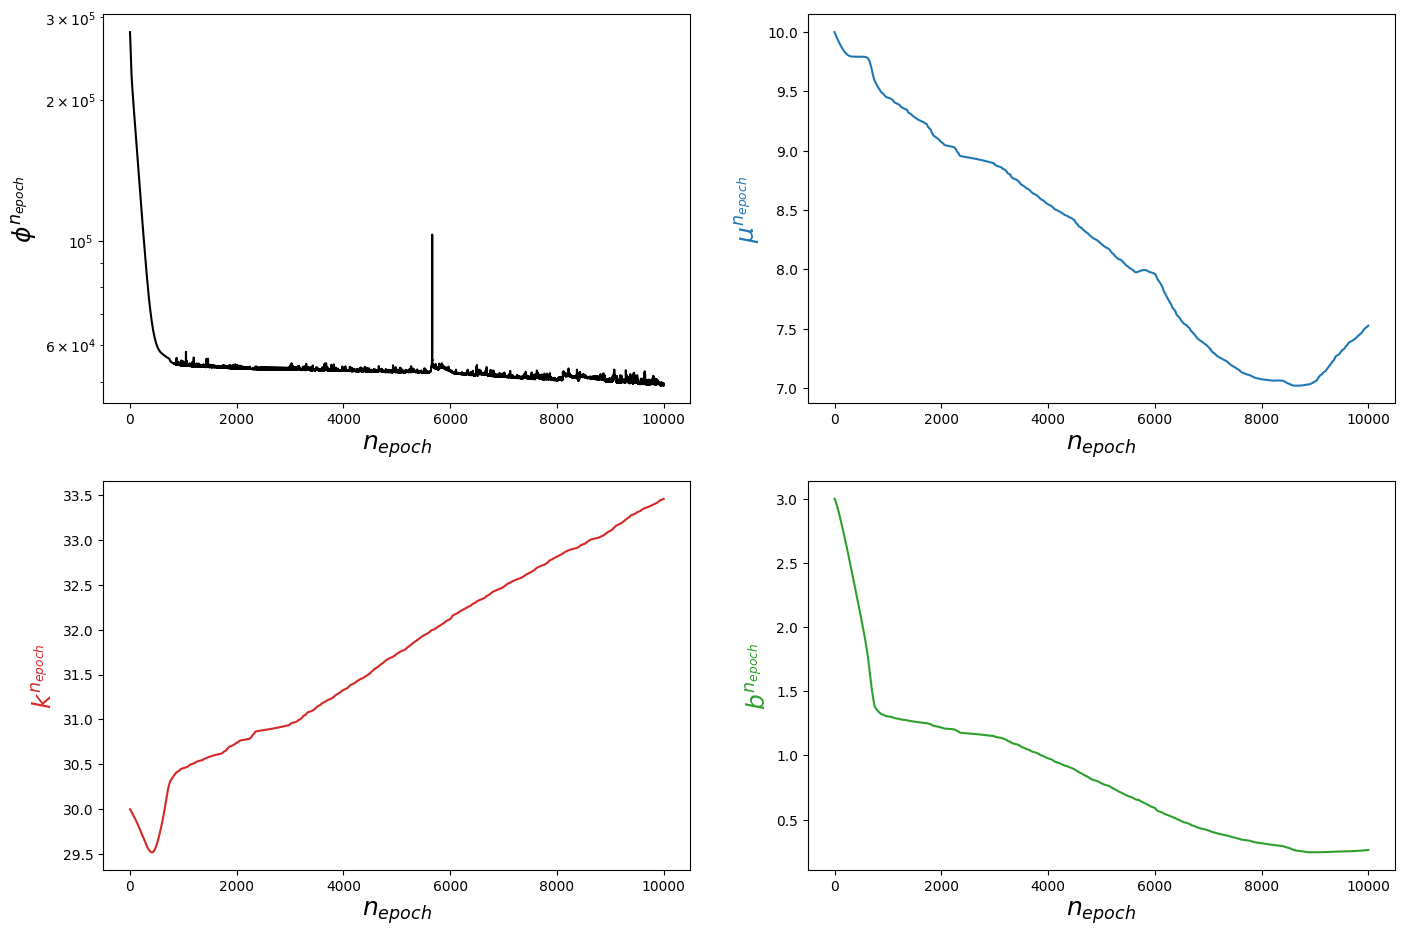

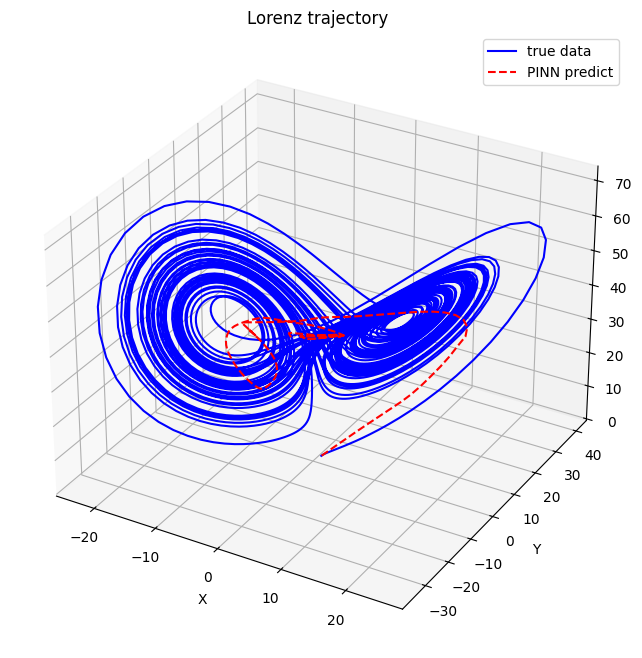

In [148]:
model = PINNIdentificationNet(output_dim=3)
solver = PINNSolver_Lorenz_ID(model, T_r)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

start_time = time.time()
solver.solve(optimizer, T_data, U_data, N=10000)
end_time = time.time()
print(f"train time: {end_time - start_time:.2f} s")

print(f"estimate: sigma={model.sigma.item():.4f}, rho={model.rho.item():.4f}, beta={model.beta.item():.4f}")

fig = solver.plot_loss_and_param()
plt.show()

def plot_trajectory(model, t_data, u_data):
    t_pred = t_data.clone().detach().requires_grad_(True)
    u_pred = model(t_pred).detach().numpy()

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(u_data[:, 0], u_data[:, 1], u_data[:, 2], 'b-', label='true data')
    ax.plot(u_pred[:, 0], u_pred[:, 1], u_pred[:, 2], 'r--', label='PINN predict')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    plt.title('Lorenz trajectory')
    plt.show()

plot_trajectory(model, T_data, U_data.numpy())

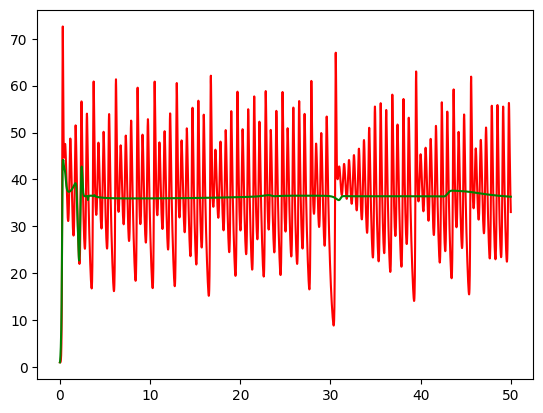

In [158]:
t_pred = T_data.clone().detach().requires_grad_(True)
u_pred = model(t_pred).detach().numpy()
plt.plot(t_lorenz, U_data[:, 2], 'r-', label='u')
plt.plot(t_lorenz, u_pred[:, 2], 'g-', label='u-')

In [150]:
params = {
    'T': 100,
    'dt': 0.01,
}
# Generate prediction points
t = np.linspace(0, params['T'], 10001)[:, None]  # More points for smoother plot

xyz_pred = model(torch.tensor(t,dtype=torch.float32))

In [156]:
import os

TEAM_FOLDER = "data"
os.makedirs(TEAM_FOLDER, exist_ok=True)

PREDICTION_FILE = os.path.join(TEAM_FOLDER, "lorenz_prediction.npy")
np.save(PREDICTION_FILE, xyz_pred.detach().numpy()[5001:10001])

print(f"Saved prediction to: {PREDICTION_FILE}")
print(f"Prediction shape: {xyz_pred[5001:10001].shape}")

Saved prediction to: data\lorenz_prediction.npy
Prediction shape: torch.Size([5000, 3])
